# Setup (same everywhere)

## Mount Drive


In [1]:
from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

/content/drive/My Drive/repositories/moleculenet/notebooks


In [3]:
%ls

all_plots.ipynb
colab_extended_ci-rf-gp_xgb-sota-check_results.ipynb
colab_extended_GPflow_pipeline.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
prepare_and_plot_extended_ci_rf_and_gp_results.ipynb
prepare_extended_grid_search_results.ipynb
prepare_reproducing_grid_search_results.ipynb


In [4]:
%ls ../data/

esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original.csv
esol_original_extra_features.csv
esol_original_IdSmilesLabels.csv
esol_original_rdkit_features.csv
ESOL_README
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
FreeSolv_README
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv
Lipo_README


## Import modules

### Standard imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# custom imports
import os
import sys

# saving models
import json
import pickle

# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

# making custom metrics
from sklearn.metrics import make_scorer

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

# pipelines
# https://scikit-learn.org/stable/modules/compose.html#combining-estimators
from sklearn.pipeline import make_pipeline, Pipeline

In [8]:
try:
    import forestci as fci
    print("Successful import")
except ImportError as e:
    ! pip install forestci
    import forestci as fci

Successful import


In [9]:
import sklearn
print(sklearn.__version__)
print(fci.__version__)

0.22.2.post1
0.4.1


### Custom imports

In [2]:
sys.path.insert(0, '..')

# preprocessing
from util_scripts.preprocessing_functions import list_highly_correlated

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels

sys.path.insert(0, './notebooks')

In [3]:
help(list_highly_correlated)

Help on function list_highly_correlated in module util_scripts.preprocessing_functions:

list_highly_correlated(df_features, targets, threshold=0.8)
    List column names of the dataframe of features which are highly correlated
    to the target (absolute value of the correlation is greater than the threshold).
    
    Parameters
    ----------
    df_features : (n, p) pandas.core.frame.DataFrame of p features
                  Input array.
    targets     : (n,) pandas.core.series.Series of targets
                  Input array.
    threshold   : float in [0, 1] above which we consider a feature highly correlated
    
    Returns
    -------
    cols_to_remove : list of column names from df_features, which are highly correlated
                     to the target



In [4]:
def make_split_generator(X, y, split_type='random', random_state=42, n_splits=1, test_size=0.1):
    assert split_type in ['random', 'stratified']

    if split_type == 'random':
        gen = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state).split(X)
    elif split_type == 'stratified':
        binned = y.apply(lambda x: int(x)) # creating stratified indices
        gen = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state).split(X, binned)
    
    # gen for generator
    return gen

## Set plotting style

In [5]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# Load Data (same everywhere)

## CHOOSE: dataset, smile_type, grid_search_type

In [47]:
dataset = 'lipophilicity'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'extended'
assert grid_search_type in ['reproducing', 'extended']

remove_highly_correlated = False
assert isinstance(remove_highly_correlated, bool)

# for saving files depending on highly-correlated feature treatment
# cf stands for correlated features
if remove_highly_correlated:
    cf = 'reduced'
else:
    cf = 'full'

In [48]:
print(dataset, smile_type, grid_search_type, cf)

lipophilicity original extended full


## Titles, Units and Labels for datasets

In [49]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [50]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


## Load Features and Targets

Leave all features here so setup and Load and prepare data are the same everywhere.

In [51]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmilesLabels.csv', index_col=0)
# labels
labels = id_smile_target['labels']

In [52]:
# fingerprints
ecfp4_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp4_features.csv', index_col=0)
ecfp6_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp6_features.csv', index_col=0)

ecfp4_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp4_features.csv', index_col=0)
ecfp6_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp6_features.csv', index_col=0)

In [53]:
# RDKit descriptors
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)

if remove_highly_correlated:
    highly_correlated_features = list_highly_correlated(rdkit_features, labels, threshold=0.75)
    print(f'\nRemoving {len(highly_correlated_features)} highly correlated feature(s).')
    rdkit_features = rdkit_features.drop(highly_correlated_features, axis=1)

In [54]:
print('rdkit_features.shape:      ', rdkit_features.shape)
print('ecfp4_1024_features.shape: ', ecfp4_1024_features.shape)
print('ecfp6_1024_features.shape: ', ecfp6_1024_features.shape)
print('ecfp4_2048_features.shape: ', ecfp4_2048_features.shape)
print('ecfp6_2048_features.shape: ', ecfp6_2048_features.shape)
print('labels.shape:              ', labels.shape)

rdkit_features.shape:       (4200, 200)
ecfp4_1024_features.shape:  (4200, 1024)
ecfp6_1024_features.shape:  (4200, 1024)
ecfp4_2048_features.shape:  (4200, 2048)
ecfp6_2048_features.shape:  (4200, 2048)
labels.shape:               (4200,)


In [55]:
labels.head()

id
CHEMBL596271     3.54
CHEMBL1951080   -1.18
CHEMBL1771       3.69
CHEMBL234951     3.37
CHEMBL565079     3.10
Name: labels, dtype: float64

## Create one DataFrame with all features

In [56]:
all_features = pd.concat([rdkit_features,
                          ecfp4_1024_features, ecfp6_1024_features,
                          ecfp4_2048_features, ecfp6_2048_features],
                         axis='columns')

In [57]:
all_features.shape

(4200, 6344)

In [58]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,2048ecfp6-2038,2048ecfp6-2039,2048ecfp6-2040,2048ecfp6-2041,2048ecfp6-2042,2048ecfp6-2043,2048ecfp6-2044,2048ecfp6-2045,2048ecfp6-2046,2048ecfp6-2047
CHEMBL596271,8.838871,-4.082382,8.838871,0.008322,0.728444,340.858,319.690,340.145474,124.0,0.0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1951080,15.117958,-6.843264,15.117958,0.920611,0.545587,494.591,468.383,494.118143,178.0,0.0,...,0,0,0,0,0,0,0,1,0,0
CHEMBL1771,13.321227,-3.906276,13.321227,0.250582,0.807761,321.829,305.701,321.059027,110.0,0.0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL234951,14.213604,-4.272077,14.213604,0.187400,0.506650,419.890,401.746,419.070655,146.0,0.0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL565079,14.167882,-4.810274,14.167882,0.671279,0.747686,381.480,354.264,381.216475,148.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# CHOOSE: what feature_sets we will iterate over

## Put original features into feature_sets
Create a dictionary containing feature names (index objects) as its elements

In [59]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    '1024ecfp-4': ecfp4_1024_features.columns,
    '1024ecfp-6': ecfp6_1024_features.columns,
    '2048ecfp-4': ecfp4_2048_features.columns,
    '2048ecfp-6': ecfp6_2048_features.columns,
}

## Adding a combination of RDKit features with every feature set in the feature_sets dictionary


In [60]:
for f in ['1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])

In [61]:
list(feature_sets.keys())

['RDKit',
 '1024ecfp-4',
 '1024ecfp-6',
 '2048ecfp-4',
 '2048ecfp-6',
 '1024ecfp-4 + RDKit',
 '1024ecfp-6 + RDKit',
 '2048ecfp-4 + RDKit',
 '2048ecfp-6 + RDKit']

# List of estimators

In [62]:
estimators = {
    'rf':  RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'krr': KernelRidge(kernel='rbf'), # 'rbf' used in the paper (defaults to 'linear')
    'gp': GaussianProcessRegressor(normalize_y=True), # normilize since we have not normalized here
}

## Load best parameters

In [63]:
with open(f'../results/{dataset}_{smile_type}_{grid_search_type}_random_search_best_params_{cf}.pickle', 'rb') as fp:
    best_params = pickle.load(fp)

In [64]:
best_params

{'RDKit': {'rf': {'rf__n_estimators': 150,
   'rf__max_features': 0.30000000000000004},
  'xgb': {'xgb__subsample': 0.5,
   'xgb__n_estimators': 200,
   'xgb__max_depth': 5,
   'xgb__learning_rate': 0.1},
  'krr': {'krr__alpha': 0.1},
  'gp': {'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)}},
 '1024ecfp-4': {'rf': {'rf__n_estimators': 950, 'rf__max_features': 0.4},
  'xgb': {'xgb__subsample': 1,
   'xgb__n_estimators': 400,
   'xgb__max_depth': 9,
   'xgb__learning_rate': 0.1},
  'krr': {'krr__alpha': 0.01},
  'gp': {'gp__kernel': RBF(length_scale=1) + WhiteKernel(noise_level=1)}},
 '1024ecfp-6': {'rf': {'rf__n_estimators': 950, 'rf__max_features': 0.6},
  'xgb': {'xgb__subsample': 1,
   'xgb__n_estimators': 400,
   'xgb__max_depth': 9,
   'xgb__learning_rate': 0.1},
  'krr': {'krr__alpha': 0.01},
  'gp': {'gp__kernel': DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)}},
 '2048ecfp-4': {'rf': {'rf__n_estimators': 500, 'rf__max_features': 0.4},
  'xgb': {'xg

# Best combination feature-set * estimator for RFs, GPs, XGBoost

In [65]:
#%ls ../tables/

In [66]:
df_best_model_featureset = pd.read_csv(f'../tables/{dataset}_{smile_type}_{grid_search_type}_{cf}_best_test_RMSE_model_x_featureset_mean_std.csv')

print('dataset', 'smile_type', 'grid_search_type', 'cf')
print(dataset, smile_type, grid_search_type, cf)
df_best_model_featureset

dataset smile_type grid_search_type cf
lipophilicity original extended full


,Model,Feature set,mean,std
0,gp,RDKit,0.633,0.026
1,xgb,1024ecfp-4 + RDKit,0.636,0.021
2,krr,RDKit,0.666,0.052
3,rf,1024ecfp-4 + RDKit,0.671,0.022
4,gpflow,2048ecfp-4,0.687,0.065


# Getting best featureset for a model of choice

## Choose model

In [67]:
f_gp = df_best_model_featureset[df_best_model_featureset['Model'] == 'gp']['Feature set'].values[0]
f_gp

'RDKit'

In [68]:
f_rf = df_best_model_featureset[df_best_model_featureset['Model'] == 'rf']['Feature set'].values[0]
f_rf

'1024ecfp-4 + RDKit'

In [69]:
f_xgb = df_best_model_featureset[df_best_model_featureset['Model'] == 'xgb']['Feature set'].values[0]
f_xgb

'1024ecfp-4 + RDKit'

# Get best parameters for rf and gp for these featuresets

In [70]:
params_gp = best_params[f_gp]['gp']
params_gp

{'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)}

In [162]:
params_rf = best_params[f_rf]['rf']
params_rf

{'rf__max_features': 0.4, 'rf__n_estimators': 950}

In [163]:
params_xgb = best_params[f_xgb]['xgb']
params_xgb

{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.5}

## Create models and check we can feed them parameters

In [164]:
rf = RandomForestRegressor(
        n_estimators = params_rf['rf__n_estimators'],
        max_features = params_rf['rf__max_features'],
        random_state=42 # add for reproducibility
        )
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=950, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [165]:
gpr = GaussianProcessRegressor(
        kernel = params_gp['gp__kernel'],
        random_state=42, # add for reproducibility
        n_restarts_optimizer=3 # add to improve performance
        )
gpr

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=3, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=42)

In [166]:
xgb = XGBRegressor(
    learning_rate = params_xgb['xgb__learning_rate'],
    max_depth = params_xgb['xgb__max_depth'],
    n_estimators = params_xgb['xgb__n_estimators'],
    subsample = params_xgb['xgb__subsample'],
    random_state =  42, # add for reproducibility
    n_jobs = -1 # add for faster computaation
)
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

## Functions to get predictions and standard errors

In [167]:
def fit_rf_ci(X_train_prepared, X_test_prepared, y_train, params_rf):
    # initiaalise
    rf = RandomForestRegressor(
        n_estimators = params_rf['rf__n_estimators'],
        max_features = params_rf['rf__max_features'],
        random_state=42)
    
    # fit
    rf.fit(X_train_prepared, y_train)
    
    # predict
    y_test_pred = rf.predict(X_test_prepared)
    
    # get CIs
    # Calculate the variance
    V_IJ_unbiased = fci.random_forest_error(rf, X_train_prepared, X_test_prepared)
    y_test_std = np.sqrt(V_IJ_unbiased)
    
    return y_test_pred, y_test_std

In [168]:
def fit_gp_ci(X_train_prepared, X_test_prepared, y_train, params_gp):
    # initiaalise
    gpr = GaussianProcessRegressor(
        kernel = params_gp['gp__kernel'],
        random_state=42,
        n_restarts_optimizer=3)
    
    # fit
    gpr.fit(X_train_prepared, y_train)
    
    # predict and get stds
    y_test_pred, y_test_std = gpr.predict(X_test_prepared, return_std=True)
    
    return y_test_pred, y_test_std

In [169]:
def fit_xgb(X_train_prepared, X_test_prepared, y_train, params_xgb):
    # initiaalise
    xgb = XGBRegressor(
        learning_rate = params_xgb['xgb__learning_rate'],
        max_depth = params_xgb['xgb__max_depth'],
        n_estimators = params_xgb['xgb__n_estimators'],
        subsample = params_xgb['xgb__subsample'],
        random_state =  42, # add for reproducibility
        n_jobs = -1 # add for faster computaation
    )
    
    # fit
    xgb.fit(X_train_prepared, y_train)
    
    # predict
    y_test_pred = xgb.predict(X_test_prepared)
    
    return y_test_pred

# Try one run and record times

In [170]:
pipe = Pipeline([('zero-var-feature-remover', VarianceThreshold()),
                 ('scaler', StandardScaler())
                ])

## One run RF

### Data

In [171]:
X = all_features[feature_sets[f_rf]].dropna(axis=0)
y = labels[X.index]
X.shape, y.shape
# X.isna().sum().sum(), y.isna().sum()

((1128, 199), (1128,))

In [172]:
split_gen = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X)

In [173]:
for train, test in split_gen:
    # train-test split
    X_train = X.iloc[train]
    y_train = y.iloc[train].values
    X_test = X.iloc[test]
    y_test = y.iloc[test].values
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((902, 199), (226, 199), (902,), (226,))

In [174]:
X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)

In [175]:
%%time
y_test_pred, y_test_std = fit_rf_ci(X_train_prepared, X_test_prepared, y_train, params_rf)

CPU times: user 17.2 s, sys: 261 ms, total: 17.4 s
Wall time: 17.2 s


## One run GP

### Data

In [176]:
X = all_features[feature_sets[f_gp]].dropna(axis=0)
y = labels[X.index]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [178]:
X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)

### Fit

In [179]:
%%time
y_test_pred, y_test_std = fit_gp_ci(X_train_prepared, X_test_prepared, y_train, params_gp)

CPU times: user 51 s, sys: 12.8 s, total: 1min 3s
Wall time: 34.5 s


## One run XGBoost

### Data

In [180]:
X = all_features[feature_sets[f_xgb]].dropna(axis=0)
y = labels[X.index]
X.shape, y.shape
# X.isna().sum().sum(), y.isna().sum()

((1128, 199), (1128,))

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [182]:
X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)

### Fit

In [183]:
%%time
y_test_pred = fit_xgb(X_train_prepared, X_test_prepared, y_train, params_xgb)

[07:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3 s, sys: 12.2 ms, total: 3.02 s
Wall time: 1.53 s


In [184]:
print(dataset, cf)

esol reduced


## Plot the results for test and train observations

# Confidence Intervals

## Calculate confidence bounds using std part of gpr predictions

In [185]:
len(y_test_pred)

226

In [186]:
upper = y_test_pred + 1.96 * y_test_std
lower = y_test_pred - 1.96 * y_test_std

In [187]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper}
)
CIs_df = CIs_df.sort_values(by='y_test')

In [188]:
CIs_df

,y_test,y_test_pred,y_test_std,lower,upper
Perylene,-8.804,-8.584476,0.398185,-9.364918,-7.804034
"2,2',3,3',5,6-PCB",-8.600,-7.843031,0.369206,-8.566675,-7.119387
Benzo(k)fluoranthene,-8.490,-8.392603,0.427852,-9.231192,-7.554013
hexacosane,-8.334,-8.124310,0.699709,-9.495741,-6.752880
Benzo(b)fluoranthene,-8.230,-7.973420,0.428365,-8.813015,-7.133825
...,...,...,...,...,...
Acephate,0.540,-1.626347,0.502494,-2.611236,-0.641458
Erythritol,0.700,0.619413,0.446967,-0.256643,1.495468
Pyridine,0.760,1.016758,0.426785,0.180260,1.853256
2-pyrrolidone,1.070,0.734826,0.464149,-0.174906,1.644558


## Plot test observations with error bars (1 std.)

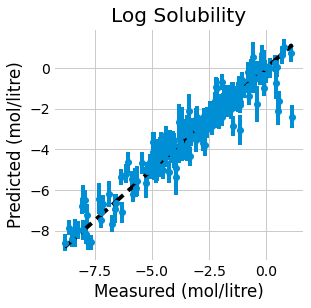

In [189]:
# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.errorbar(x=CIs_df.y_test, y=CIs_df.y_test_pred, yerr=CIs_df.y_test_std, fmt='o')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

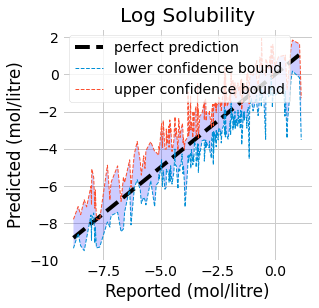

In [190]:
fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)

ax.set_xlabel(f'Reported {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.set_title(f'{datasets_to_titles[dataset]}')
ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [191]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis

Perylene                 True
2,2',3,3',5,6-PCB       False
Benzo(k)fluoranthene     True
hexacosane               True
Benzo(b)fluoranthene     True
                        ...  
Acephate                False
Erythritol               True
Pyridine                 True
2-pyrrolidone            True
vamidothion             False
Length: 226, dtype: bool

In [192]:
within_cis.sum() / len(within_cis)

0.8938053097345132

# Multiple runs RF (preprocessing is separate since we have separate features)

In [193]:
# %%time

# X = all_features[feature_sets[f_rf]].dropna(axis=0)
# y = labels[X.index]
# #X.shape, y.shape
# #X.isna().sum().sum(), y.isna().sum()

# # change to more afterwarts
# split_gen = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42).split(X)

# # for records
# dict_test_true = {}
# dict_test_pred = {}
# dict_test_std = {}

# count = 0
# for train, test in split_gen:
#     # train-test split
#     X_train = X.iloc[train]
#     y_train = y.iloc[train].values
#     X_test = X.iloc[test]
#     y_test = y.iloc[test].values
        
#     # zero-var-reduction and scaling
#     X_train_prepared = pipe.fit_transform(X_train)
#     X_test_prepared = pipe.transform(X_test)
        
#     # getting predictions with uncertainties
#     y_test_pred, y_test_std = fit_rf_ci(X_train_prepared, X_test_prepared, y_train, params_rf)
        
#     # record results to dictionaries
#     dict_test_true[f'test_true_{count}'] = y_test
#     dict_test_pred[f'test_pred_{count}'] = y_test_pred
#     dict_test_std[f'test_std_{count}'] = y_test_std
    
#     # into dataframes
#     df_test_true = pd.DataFrame(dict_test_true)
#     df_test_pred = pd.DataFrame(dict_test_pred)
#     df_test_std = pd.DataFrame(dict_test_std)
    
#     # increment for saving results
#     count += 1
    
#     # save results as csv-s, rewrite each time
#     df_test_true.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_rf.csv', index=False)
#     df_test_pred.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_rf.csv', index=False)
#     df_test_std.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_rf.csv', index=False)

CPU times: user 8min 33s, sys: 7.39 s, total: 8min 40s
Wall time: 8min 36s


In [194]:
print('Done with RF')

Done with RF


# Multiple runs GP (preprocessing is separate since we have separate features)

In [195]:
# %%time

# X = all_features[feature_sets[f_gp]].dropna(axis=0)
# y = labels[X.index]
# #X.shape, y.shape
# #X.isna().sum().sum(), y.isna().sum()

# # change to more afterwarts
# split_gen = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42).split(X)

# # for records
# dict_test_true = {}
# dict_test_pred = {}
# dict_test_std = {}

# count = 0
# for train, test in split_gen:
#     # train-test split
#     X_train = X.iloc[train]
#     y_train = y.iloc[train].values
#     X_test = X.iloc[test]
#     y_test = y.iloc[test].values
        
#     # zero-var-reduction and scaling
#     X_train_prepared = pipe.fit_transform(X_train)
#     X_test_prepared = pipe.transform(X_test)
        
#     # getting predictions with uncertainties
#     y_test_pred, y_test_std = fit_gp_ci(X_train_prepared, X_test_prepared, y_train, params_gp)
        
#     # record results to dictionaries
#     dict_test_true[f'test_true_{count}'] = y_test
#     dict_test_pred[f'test_pred_{count}'] = y_test_pred
#     dict_test_std[f'test_std_{count}'] = y_test_std
    
#     # into dataframes
#     df_test_true = pd.DataFrame(dict_test_true)
#     df_test_pred = pd.DataFrame(dict_test_pred)
#     df_test_std = pd.DataFrame(dict_test_std)
    
#     # increment for saving results
#     count += 1
    
#     # save results as csv-s, rewrite each time
#     df_test_true.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_gp.csv', index=False)
#     df_test_pred.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_gp.csv', index=False)
#     df_test_std.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_gp.csv', index=False)

In [196]:
print('Done with GP')

Done with GP


# Multiple runs XGBoost, check for SOTA (preprocessing is separate since we have separate features)

In [197]:
# %%time

# X = all_features[feature_sets[f_xgb]].dropna(axis=0)
# y = labels[X.index]

# # change to more afterwarts
# split_gen = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42).split(X)

# # for records
# dict_test_true = {}
# dict_test_pred = {}
# # dict_test_std = {}

# count = 0
# for train, test in split_gen:
#     # train-test split
#     X_train = X.iloc[train]
#     y_train = y.iloc[train].values
#     X_test = X.iloc[test]
#     y_test = y.iloc[test].values
        
#     # zero-var-reduction and scaling
#     X_train_prepared = pipe.fit_transform(X_train)
#     X_test_prepared = pipe.transform(X_test)
        
#     # getting predictions with uncertainties
#     y_test_pred = fit_xgb(X_train_prepared, X_test_prepared, y_train, params_xgb)
        
#     # record results to dictionaries
#     dict_test_true[f'test_true_{count}'] = y_test
#     dict_test_pred[f'test_pred_{count}'] = y_test_pred
#     # dict_test_std[f'test_std_{count}'] = y_test_std
    
#     # into dataframes
#     df_test_true = pd.DataFrame(dict_test_true)
#     df_test_pred = pd.DataFrame(dict_test_pred)
#     # df_test_std = pd.DataFrame(dict_test_std)
    
#     # increment for saving results
#     count += 1
    
#     # save results as csv-s, rewrite each time
#     df_test_true.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_xgb.csv', index=False)
#     df_test_pred.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_xgb.csv', index=False)
#     # df_test_std.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_xgb.csv', index=False)

[07:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re